# Hartree Fock State Energy
ハートリーフォック近似によって得られるエネルギーの値を，第二量子化の方法を使ってpythonで計算する．

In [2]:
from qulacs import *
from qulacs.gate import *
from qulacs.state import *
from openfermion.chem import MolecularData
from openfermion.transforms import get_fermion_operator, jordan_wigner
from openfermionpyscf import run_pyscf
from pyscf import fci

In [3]:
## basis,multiplicity,charge,geometry(原子種と原子の位置),descriptionを定義する．
basis = "sto-3g"
multiplicity = 1
charge = 0
distance  = 0.7414 #Å単位
geometry = [["H", [0,0,0]],["H", [0,0,distance]]]
description  = "tmp"

In [4]:
from qulacs import Observable
from qulacs.observable import *

## OpenFermionのmolecular-dataを読み取る
molecule = MolecularData(geometry, basis, multiplicity, charge, description) #openfermionのMolecularDataをもとに
molecule = run_pyscf(molecule,run_scf=1,run_fci=1)

## ハミルトニアンを生成する．
fermionic_hamiltonian = get_fermion_operator(molecule.get_molecular_hamiltonian())
jw_hamiltonian = jordan_wigner(fermionic_hamiltonian)

## ハミルトニアンをQulacsに使える形に直す
qulacs_hamiltonian = create_observable_from_openfermion_text(str(jw_hamiltonian))

nqubit,nelectron = molecule.n_qubits,molecule.n_electrons
print(nqubit,nelectron)

4 2


In [5]:
### Hartree Fock State
def HF_state(nqubit,nelectron):
    state = QuantumState(nqubit)
    circuit = QuantumCircuit(nqubit)
    for i in range(nelectron):
        circuit.add_gate(X(i))
    circuit.update_quantum_state(state)
    return state

hf_energy = qulacs_hamiltonian.get_expectation_value(HF_state(nqubit,nelectron))
print("HF Energy: {} Hartree".format(hf_energy))

### FCI
exact_energy = molecule.fci_energy
print("Exact Energy: {} Hartree".format(exact_energy))

HF Energy: -1.116684387085341 Hartree
Exact Energy: -1.1372701746609035 Hartree


## 結果
H$_2$ 結合距離0.7414Å HF Energy:-1.116684387085341 Hartree,Exact Energy:-1.1372701746609035 Hartree<br>
N$_2$ 結合距離1.0977Å HF Energy:-107.49589330783462 Hartree,Exact Energy:-107.4958933009819 Hartree<br>
O$_2$ 結合距離1.2075Å HF Energy:-147.55109386392724 Hartree,Exact Energy:-147.74403543362024 Hartree

## ポテンシャルエネルギー曲線

In [6]:
def HF_state(nqubit,nelectron):
    state = QuantumState(nqubit)
    circuit = QuantumCircuit(nqubit)
    for i in range(nelectron):
        circuit.add_gate(X(i))
    circuit.update_quantum_state(state)
    return state

def HF_potential(distance):
    """
    calculate potential energy of molecule
    distance unit is Å
    """
    basis = "sto-3g"
    multiplicity = 1
    charge = 0
    geometry = [["H", [0,0,0]],["H", [0,0,distance]]]
    description  = "tmp"
    
    ## OpenFermionのmolecular-dataを読み取る
    molecule = MolecularData(geometry, basis, multiplicity, charge, description) #openfermionのMolecularDataをもとに
    molecule = run_pyscf(molecule,run_scf=1,run_fci=1)

    ## ハミルトニアンを生成する．
    fermionic_hamiltonian = get_fermion_operator(molecule.get_molecular_hamiltonian())
    jw_hamiltonian = jordan_wigner(fermionic_hamiltonian)

    ## ハミルトニアンをQulacsに使える形に直す
    qulacs_hamiltonian = create_observable_from_openfermion_text(str(jw_hamiltonian))

    nqubit,nelectron = molecule.n_qubits,molecule.n_electrons
    
    hf_energy = qulacs_hamiltonian.get_expectation_value(HF_state(nqubit,nelectron))
    exact_energy = molecule.fci_energy
    
    return hf_energy,exact_energy

In [10]:
import numpy as np

distance = np.linspace(0.1,2.5,2401) ###時間結構かかる(1101で4分くらい)
hf,exact = [],[]
for i in distance:
    result = HF_potential(i)
    hf.append(result[0])
    exact.append(result[1])

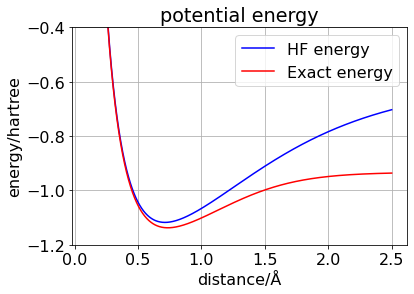

In [13]:
import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 16

x=distance#定義域の設定
plt.plot(x,hf,color='blue',label="HF energy")
plt.plot(x,exact,color='red',label="Exact energy")


plt.title('potential energy')#title
plt.xlabel('distance/Å')
plt.ylabel('energy/hartree')

# 目盛線と目盛値を配列で指定．
## 目盛線の指定．
plt.grid()
##目盛値(及び目盛線)の指定．
plt.xticks()
plt.yticks()

plt.ylim([-1.2,-0.40])
plt.legend()
plt.show()

In [ ]:
核間距離が長い領域では，電子相関が大きくなる傾向が見られた．
エネルギーが上がった(反結合性軌道に電子が入った)結果，結合長(結合次数)が伸びたため？
結合長と結合次数が対応しているというのは，量子化学の講義でそれとなく出てきたが，式で書くとどうなるのだろう？

In [14]:
## 結果を載せておく
print(x)
print(hf)
print(exact)


[0.1   0.101 0.102 ... 2.498 2.499 2.5  ]
[2.7158873932927565, 2.664189461399797, 2.6135247931389354, 2.5638634392503743, 2.5151766011700585, 2.4674365762298294, 2.4206167059596586, 2.3746913272889176, 2.3296357264589216, 2.285426095472493, 2.242039490919197, 2.199453795026393, 2.157647678796947, 2.116600567104456, 2.0762926056256577, 2.0367046294982742, 1.9978181336001766, 1.9596152443527695, 1.922078692958329, 1.885191789986802, 1.8489384012334376, 1.813302924773677, 1.7782702691466588, 1.7438258326030436, 1.7099554833571484, 1.6766455407870793, 1.643882757530243, 1.6116543024248835, 1.5799477442513261, 1.5487510362296062, 1.5180525012326973, 1.4878408176771287, 1.458105006055053, 1.428834416074015, 1.400018714372675, 1.371647872782607, 1.3437121571080899, 1.3162021163973958, 1.2891085726806613, 1.2624226111508436, 1.2361355707656034, 1.210239035249212, 1.1847248244747475, 1.1595849862080485, 1.1348117881956812, 1.1103977105804712, 1.0863354386288164, 1.0626178557549126, 1.0392380368